# Descripción del Proyecto

## Información General
Etapa de familiarización con los datos y los resultados de la prueba
## Preparación y enriquecimiento de datos
Etapa de adición de columnas, modificación de formatos y demás elementos que componen el análisis exploratorio de los datos
## Estudio y comprobación de datos
Etapa dedicada a la revisión de distribución de datos y eliminación de valores atípicos
## Estudio del embudo de eventos
Etapa enfocada en el cálculo de métricas de embudos separadas por eventos y grupos experimentales
## Conclusiones Generales


# Descripción de los datos
- **Tabla Logs** (Tabla con los datos de ocurrencia de eventos):

    - **EventName**: nombre del evento
    
    - **DeviceIDHash**: identificador de usuario unívoco
    
    - **EventTimestamp**: hora del evento
    
    - **ExpId**: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba

-------------

# 1. Información General

In [1]:
# Importación de librerias
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import math
import datetime 

In [ ]:
# Carga inicial de dataset
df = pd.read_csv('C:\Users\JANUS\OneDrive\Escritorio\Analisis de Datos\Proyecto 11 - Análisis de negocio basado en eventos\logs_exp_us.csv', sep='\t')

print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


--------------
# 2. Preparación y enriquecimiento de datos

In [3]:
# Cambio de nombre y formato de columnas
df.columns = df.columns.str.lower().str.strip()
df.rename(columns={'eventname':'event','eventtimestamp':'event_ts','deviceidhash':'user_id','expid':'group'}, inplace=True)

# Comprobación de valores ausentes y duplicados 
print(f'Conteo de valores ausentes: \n{df.isna().sum()} \n')
print(f'Conteo incial de datos duplicados: {df.duplicated().sum()}')

df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

print(f'Conteo de datos duplicados luego de limpiar el dataset: {df.duplicated().sum()}')
print('--------------------------------------------------------')

# Correción de tipos de datos
df[['event','user_id','group']] = df[['event','user_id','group']].astype('str')

# Adición de columnas con fecha y hora
df['event_datetime'] = df['event_ts'].map(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df['event_datetime'] = pd.to_datetime(df['event_datetime']).round('60 min')
df['event_date'] = pd.to_datetime(df['event_datetime'].dt.date, format='%Y-%m-%d')
df.drop(columns='event_ts', inplace=True)

print()
print(df.info())
display(df.head())

Conteo de valores ausentes: 
event       0
user_id     0
event_ts    0
group       0
dtype: int64 

Conteo incial de datos duplicados: 413
Conteo de datos duplicados luego de limpiar el dataset: 0
--------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event           243713 non-null  object        
 1   user_id         243713 non-null  object        
 2   group           243713 non-null  object        
 3   event_datetime  243713 non-null  datetime64[ns]
 4   event_date      243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 9.3+ MB
None


,event,user_id,group,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,246,2019-07-25 05:00:00,2019-07-25
1,MainScreenAppear,7416695313311560658,246,2019-07-25 11:00:00,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,248,2019-07-25 11:00:00,2019-07-25
3,CartScreenAppear,3518123091307005509,248,2019-07-25 11:00:00,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,248,2019-07-25 12:00:00,2019-07-25


Comentarios:
1. No se encontraron valores ausentes en el dataset
2. Se encontraron un total de 413 filas duplicadas, las cuales fueron excluídas para evitar errores en cálculos posteriores
3. Las columnas de user_id y group fueron convertidas a tipo str para evitar incluirlas erróneamente en cálculos futuros
4. Se incluyeron las columnas con la fecha y hora de evento. Adicionalmente, se suprimió la columna original (event_ts) pues se considera que no es práctico conservarla por el formato que manejaba

-------------
# 3. Estudio y comprobación de datos

In [4]:
# ¿Cuántos eventos hay en los registros?
print(f"Cantidad de eventos únicos: {df['event'].nunique()}")
print(f"Conteo total de eventos ocurridos: {df['event'].count()}")
print()
print(df['event'].value_counts())

Cantidad de eventos únicos: 5
Conteo total de eventos ocurridos: 243713

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64


In [5]:
# ¿Cuántos usuarios hay en los registros?
print(f"Cantidad de usuarios únicos: {df['user_id'].nunique()}")

Cantidad de usuarios únicos: 7551


In [6]:
# ¿Cuál es el promedio de eventos por usuario?
grouped_events = df.groupby('user_id')['event'].count().sort_values(ascending=False)

print(f"Promedio de eventos por usuario: {math.floor(grouped_events.median())}")

Promedio de eventos por usuario: 20


Fecha mínima: 2019-07-25 05:00:00
Fecha máxima: 2019-08-07 21:00:00
Tiempo total transcurrido en días: 13.7


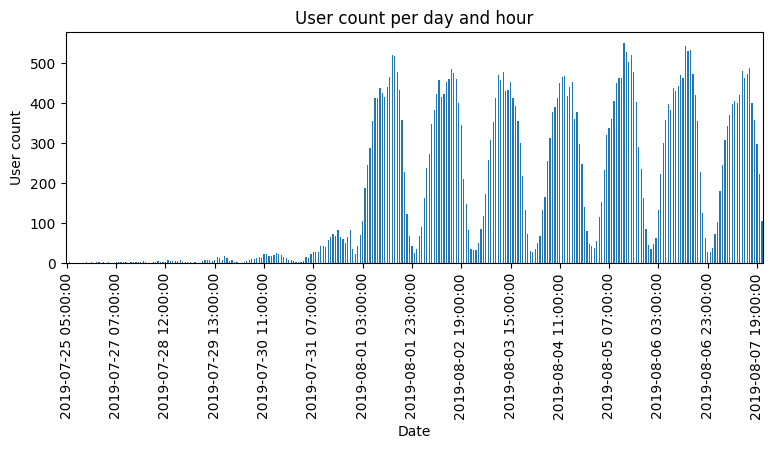


Fecha mínima (donde los datos comenzaron a estabilizarse): 2019-07-31 22:00:00
Fecha máxima (donde los datos comenzaron a estabilizarse): 2019-08-07 21:00:00
Tiempo total transcurrido en días: 7.0


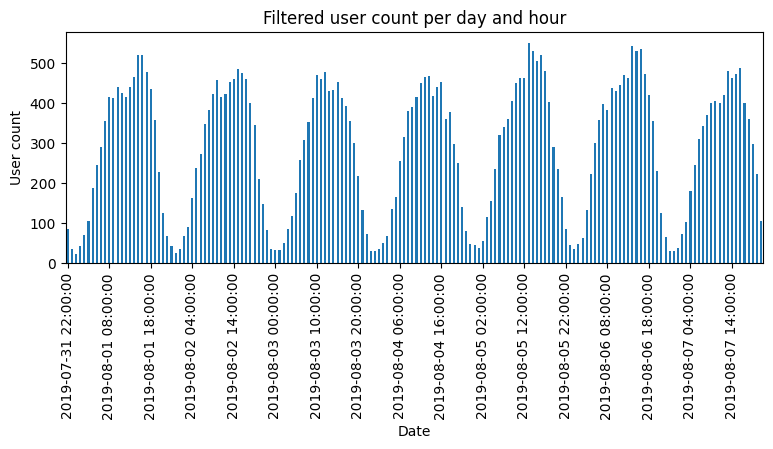

In [7]:
# Cálculo de fechas mínima y máxima
print(f"Fecha mínima: {df['event_datetime'].min()}")
print(f"Fecha máxima: {df['event_datetime'].max()}")
print(f"Tiempo total transcurrido en días: {round((df['event_datetime'].max()-df['event_datetime'].min())/np.timedelta64(1,'D'),1)}")

# Gráfico de frecuencia por fecha y hora
freq = df.groupby(['event_date','event_datetime'], as_index=False)['user_id'].nunique().sort_values(by='event_datetime')
freq.reset_index(inplace=True)

ticks=[]
step = 20
count=0
for x in freq.index:
    if x == count:
        ticks.append(freq.loc[x,'event_datetime'])
        count += step

freq['user_id'].plot(kind='bar', figsize=(9,3))
plt.xticks(np.arange(0, freq['event_datetime'].count(), step), ticks)
plt.xlabel('Date')
plt.ylabel('User count')
plt.title('User count per day and hour')
plt.show()
print()

# Gráfico de frecuencia por fecha y hora a partir del momento en que se estabilizan los datos
freq = freq.query('event_datetime >= "2019-07-31 22:00:00"')
freq.reset_index(inplace=True)

ticks=[]
step = 10
count=0
for x in freq.index:
    if x == count:
        ticks.append(freq.loc[x,'event_datetime'])
        count += step

print(f"Fecha mínima (donde los datos comenzaron a estabilizarse): {freq['event_datetime'].min()}")
print(f"Fecha máxima (donde los datos comenzaron a estabilizarse): {freq['event_datetime'].max()}")
print(f"Tiempo total transcurrido en días: {round((freq['event_datetime'].max()-freq['event_datetime'].min())/np.timedelta64(1,'D'),1)}")        
        
freq['user_id'].plot(kind='bar', figsize=(9,3))
plt.xticks(np.arange(0, freq['event_datetime'].count(), step), ticks)
plt.xlabel('Date')
plt.ylabel('User count')
plt.title('Filtered user count per day and hour')
plt.show()

Comentarios:
1. Se logró establecer que se recolectó información por aproximadamente 14 días
2. A partir de la distribución de usuarios únicos por fecha y hora se puede concluir que los datos comenzaron a mostrar un comportamiento estable hasta despúes de 2019-07-31 a las 22:00
3. Una vez filtrados los datos, se logró identificar que los datos a utilizar fueron recolectados por tan solo 7 días, la mitad del tiempo total en que se recolectó información

In [8]:
# ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?
filtered_df = df.query('event_datetime >= "2019-07-31 22:00:00"')

# Variación en los registros
print(f"Cantidad de eventos únicos: {filtered_df['event'].nunique()}")
print()

print(f"Conteo total de eventos ocurridos (sin filtrar): {df['event'].count()}")
print(f"Conteo total de eventos ocurridos (después del filtrado): {filtered_df['event'].count()}")
print(f"Cantidad de eventos descartados: {df['event'].count()-filtered_df['event'].count()}")
print()

# Variación en cantidad de usuarios
print(f"Cantidad de usuarios únicos (sin filtrar): {df['user_id'].nunique()}")
print(f"Cantidad de usuarios únicos (después del filtrado): {filtered_df['user_id'].nunique()}")
print(f"Cantidad de usuarios descartados: {df['user_id'].nunique()-filtered_df['user_id'].nunique()}")
print()

# Variación en promedio de eventos
print(f"Promedio de eventos por usuario (sin filtrar): {math.floor(grouped_events.median())}")

grouped_events = filtered_df.groupby('user_id')['event'].count().sort_values(ascending=False)

print(f"Promedio de eventos por usuario (después del filtrado): {math.floor(grouped_events.median())}")

Cantidad de eventos únicos: 5

Conteo total de eventos ocurridos (sin filtrar): 243713
Conteo total de eventos ocurridos (después del filtrado): 241491
Cantidad de eventos descartados: 2222

Cantidad de usuarios únicos (sin filtrar): 7551
Cantidad de usuarios únicos (después del filtrado): 7538
Cantidad de usuarios descartados: 13

Promedio de eventos por usuario (sin filtrar): 20
Promedio de eventos por usuario (después del filtrado): 19


Comentarios:
1. Se identificó una disminución de 2222 eventos luego de realizar el filtrado
2. El número de usuarios registrados en el periodo filtrado es 13 usuarios menor al calculado originalmente
3. El promedio de eventos por usuario se redujo de 20 a 19 una vez filtrados los datos

In [9]:
# Conteo de usuarios por grupo
group_count = filtered_df.groupby('group')['user_id'].nunique().reset_index(name='user_count')
display(group_count)

,group,user_count
0,246,2484
1,247,2517
2,248,2537


-------------
# 4. Estudio del embudo de eventos

In [10]:
# Eventos registrados y su frecuencia de suceso
grouped_reg = filtered_df['event'].value_counts().reset_index(name='event_count')
grouped_reg.rename(columns={'index':'event'}, inplace=True)

display(grouped_reg)

,event,event_count
0,MainScreenAppear,117745
1,OffersScreenAppear,46472
2,CartScreenAppear,42327
3,PaymentScreenSuccessful,33939
4,Tutorial,1008


In [11]:
# Cantidad de usuarios que realizaron cada una de estas acciones al menos una vez
grouped_users = filtered_df.groupby('event')['user_id'].nunique().reset_index(name='user_count')
grouped_users = grouped_users.merge(grouped_reg, on='event').sort_values(by='event_count', ascending=False)
grouped_users = grouped_users[['event','event_count','user_count']]

# Proporción de usuarios que realizaron la acción 
grouped_users['general_proportion(%)'] = round(grouped_users['user_count']*100/filtered_df['user_id'].nunique(),2)

display(grouped_users)

,event,event_count,user_count,general_proportion(%)
1,MainScreenAppear,117745,7423,98.47
2,OffersScreenAppear,46472,4596,60.97
0,CartScreenAppear,42327,3735,49.55
3,PaymentScreenSuccessful,33939,3539,46.95
4,Tutorial,1008,842,11.17


Comentarios:
1. De los datos anteriores se puede evidenciar que el flujo de acciones corresponde a MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful
2. Se considera que la etapa Tutorial no hace parte de la misma secuencia de acciones y que puede ser descartada para cálculos posteriores, pues no afecta el flujo de eventos

In [12]:
# Proporción de usuarios que pasan de una etapa a la siguiente del embudo
filtered_df = filtered_df[filtered_df['event'] != 'Tutorial']

users = filtered_df.pivot_table(index='user_id', 
                                columns='event', 
                                values='event_datetime',
                                aggfunc='min')

step1 = ~users['MainScreenAppear'].isna()
step2 = step1 & (users['OffersScreenAppear']>users['MainScreenAppear'])
step3 = step2 & (users['CartScreenAppear']>users['OffersScreenAppear'])
step4 = step3 & (users['PaymentScreenSuccessful']>users['CartScreenAppear'])

n_s1 = users[step1].shape[0]
n_s2 = users[step2].shape[0]
n_s3 = users[step3].shape[0]
n_s4 = users[step4].shape[0]

data = {'event':['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'],
        'funnel_user_count':[n_s1,n_s2,n_s3,n_s4]}

stages = pd.DataFrame(data=data, index=[0,1,2,3])
stages['stage_proportion(%)'] = (stages['funnel_user_count']
                                 .map(lambda x: round(x*100/stages[stages['funnel_user_count']>x]['funnel_user_count'].min(),2)))

stages.fillna('-', inplace=True)

display(stages)

,event,funnel_user_count,stage_proportion(%)
0,MainScreenAppear,7423,-
1,OffersScreenAppear,1100,14.82
2,CartScreenAppear,138,12.55
3,PaymentScreenSuccessful,8,5.8


Comentarios:
1. Al analizar los porcentajes de retención entre una etapa y otra se puede observar que la etapa donde mayor impacto se ve está después de que los usuarios han ingresado a revisar el carrito (CartScreenAppear) y proceden a pagar (PaymentScreenSuccessful)
2. Se pudo observar también que la tasa entre las primeras 3 etapas es bastante similar, variando tan solo 2.3%

In [13]:
# Porcentaje de usuarios que hace todo el viaje desde el primer evento hasta el pago
funnel_conversion = stages['funnel_user_count'].min()*100/stages['funnel_user_count'].max()
print(f'Porcentaje de usuarios que hace todo el viaje desde el primer evento hasta el pago: {round(funnel_conversion,2)}%')

Porcentaje de usuarios que hace todo el viaje desde el primer evento hasta el pago: 0.11%


-------------
# 5. Estudio de resultados del experimento

In [14]:
# Cantidad de usuarios por grupo
group_count = filtered_df.groupby('group')['user_id'].nunique().reset_index(name='user_count')
display(group_count)

,group,user_count
0,246,2483
1,247,2516
2,248,2535


In [15]:
# Revisión de diferencia estadísticamente significativa entre las muestras 246 y 247

# Creación de muestras separadas por grupo
sample_A1 = (filtered_df
             .query('group == "246"')
             .groupby('event')['user_id'].nunique()
             .reset_index(name='user_count')
             .sort_values(by='user_count', ascending=False))

sample_A2 = (filtered_df
             .query('group == "247"')
             .groupby('event')['user_id'].nunique()
             .reset_index(name='user_count')
             .sort_values(by='user_count', ascending=False))

# Comparación estadística de proporciones
n1 = sample_A1['user_count'].max()
n2 = sample_A2['user_count'].max()

p1 = sample_A1['user_count'].min()/n1
p2 = sample_A2['user_count'].min()/n2

p_combined = (sample_A1['user_count'].min() + sample_A2['user_count'].min())/(n1 + n2)

z_value = abs((p1 - p2)/math.sqrt(p_combined*(1 - p_combined)*(1/n1 + 1/n2)))

distr = st.norm(0,1)

p_value = (1 - distr.cdf(z_value))*2

print(f'Valor p para prueba de igualdad de proporciones entre grupos experimentales: {round(p_value,3)} ({round(p_value*100,2)}%)')
print()

alpha = 0.05

if p_value < alpha:
    print("Hipótesis nula rechazada: El comportamiento de los grupos experimentales indica que existe una diferencia significativa entre las proporciones de las muestras")
else:
    print("Hipótesis nula aceptada: El comportamiento de los grupos experimentales indica que no existe una diferencia significativa entre las proporciones de las muestras")

Valor p para prueba de igualdad de proporciones entre grupos experimentales: 0.111 (11.11%)

Hipótesis nula aceptada: El comportamiento de los grupos experimentales indica que no existe una diferencia significativa entre las proporciones de las muestras


In [16]:
# Cálculo de proporciones y significación estadística con datos filtrados

# Evento más popular
print(f"\033[1mEvento más popular:\033[0m {grouped_reg.loc[0,'event']}")
print()
print()

# Cantidad de usuarios que realizaron cada acción en cada grupo de control
grouped_actions = filtered_df.groupby(['event','group'], as_index=False)['user_id'].nunique().sort_values(by='user_id', ascending=False)
grouped_actions.rename(columns={'user_id':'user_count'}, inplace=True)

grouped_actions = grouped_actions.pivot_table(index='event', 
                                              columns='group', 
                                              values='user_count',
                                              aggfunc='mean')

print(f'\033[1mCantidad total de usuarios por acción para cada grupo\033[0m')
display(grouped_actions.sort_values(by='246', ascending=False))
print()
print()

# Proporción de usuarios que pasan de una etapa a la siguiente del embudo
def stage_proportion(data, group):
    group = str(group)
    
    users = data[data['group'] == group].pivot_table(index='user_id', 
                                                     columns='event', 
                                                     values='event_datetime',
                                                     aggfunc='min')

    step1 = ~users['MainScreenAppear'].isna()
    step2 = step1 & (users['OffersScreenAppear']>users['MainScreenAppear'])
    step3 = step2 & (users['CartScreenAppear']>users['OffersScreenAppear'])
    step4 = step3 & (users['PaymentScreenSuccessful']>users['CartScreenAppear'])

    n_s1 = users[step1].shape[0]
    n_s2 = users[step2].shape[0]
    n_s3 = users[step3].shape[0]
    n_s4 = users[step4].shape[0]

    stage_data = {'event':['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'],
                  'funnel_user_count':[n_s1,n_s2,n_s3,n_s4]}
    
    stages = pd.DataFrame(data=stage_data, index=[0,1,2,3])
    stages['stage_proportion(%)'] = (stages['funnel_user_count']
                                     .map(lambda x: round(x*100/stages[stages['funnel_user_count']>x]['funnel_user_count'].min(),2)))

    stages.fillna('-', inplace=True)
    print(f'\033[1mEmbudo de compras para el grupo {group}\033[0m')
    return stages

display(stage_proportion(filtered_df,246))
print()
print()
display(stage_proportion(filtered_df,247))
print()
print()
display(stage_proportion(filtered_df,248))

# Comparación estadística de proporciones entre grupos
stat_comparison_cnt = 0

def stat_comparison(data, A, B, alpha=0.05):
    global stat_comparison_cnt
    stat_comparison_cnt += 1
    
    A = str(A)
    B = str(B)
    
    sample_A = (data[data['group'] == A]
                .groupby('event')['user_id'].nunique()
                .reset_index(name='user_count')
                .sort_values(by='user_count', ascending=False))

    sample_B = (data[data['group'] == B]
                .groupby('event')['user_id'].nunique()
                .reset_index(name='user_count')
                .sort_values(by='user_count', ascending=False))

    n1 = sample_A['user_count'].max()
    n2 = sample_B['user_count'].max()

    p1 = sample_A['user_count'].min()/n1
    p2 = sample_B['user_count'].min()/n2

    p_combined = (sample_A['user_count'].min() + sample_B['user_count'].min())/(n1 + n2)

    z_value = abs((p1 - p2)/math.sqrt(p_combined*(1 - p_combined)*(1/n1 + 1/n2)))

    distr = st.norm(0,1)

    p_value = (1 - distr.cdf(z_value))*2

    print('--------------------------------------------------------------------------------') 
    print(f'Valor p para prueba de igualdad de proporciones entre los grupos {A} y {B}: {round(p_value,3)} ({round(p_value*100,2)}%)')
    print()

    if p_value < alpha:
        print(f"Hipótesis nula rechazada: El comportamiento de los grupos experimentales indica que existe una diferencia significativa entre las proporciones de las muestras {A} y {B}")
    else:
        print(f"Hipótesis nula aceptada: El comportamiento de los grupos experimentales indica que no existe una diferencia significativa entre las proporciones de las muestras {A} y {B}")
    return
 
print(stat_comparison(filtered_df, 246, 247, 0.0019))   
print(stat_comparison(filtered_df, 246, 248, 0.0019))    
print(stat_comparison(filtered_df, 247, 248, 0.0019))

Evento más popular: MainScreenAppear


Cantidad total de usuarios por acción para cada grupo


group,246,247,248
event,,,
MainScreenAppear,2450,2479,2494
OffersScreenAppear,1542,1523,1531
CartScreenAppear,1266,1239,1230
PaymentScreenSuccessful,1200,1158,1181




Embudo de compras para el grupo 246


,event,funnel_user_count,stage_proportion(%)
0,MainScreenAppear,2450,-
1,OffersScreenAppear,370,15.1
2,CartScreenAppear,46,12.43
3,PaymentScreenSuccessful,1,2.17




Embudo de compras para el grupo 247


,event,funnel_user_count,stage_proportion(%)
0,MainScreenAppear,2479,-
1,OffersScreenAppear,368,14.84
2,CartScreenAppear,48,13.04
3,PaymentScreenSuccessful,4,8.33




Embudo de compras para el grupo 248


,event,funnel_user_count,stage_proportion(%)
0,MainScreenAppear,2494,-
1,OffersScreenAppear,362,14.51
2,CartScreenAppear,44,12.15
3,PaymentScreenSuccessful,3,6.82


--------------------------------------------------------------------------------
Valor p para prueba de igualdad de proporciones entre los grupos 246 y 247: 0.111 (11.11%)

Hipótesis nula aceptada: El comportamiento de los grupos experimentales indica que no existe una diferencia significativa entre las proporciones de las muestras 246 y 247
None
--------------------------------------------------------------------------------
Valor p para prueba de igualdad de proporciones entre los grupos 246 y 248: 0.253 (25.26%)

Hipótesis nula aceptada: El comportamiento de los grupos experimentales indica que no existe una diferencia significativa entre las proporciones de las muestras 246 y 248
None
--------------------------------------------------------------------------------
Valor p para prueba de igualdad de proporciones entre los grupos 247 y 248: 0.651 (65.05%)

Hipótesis nula aceptada: El comportamiento de los grupos experimentales indica que no existe una diferencia significativa entre l

In [17]:
# Comparación de proporciones para eventos específicos entre grupos
group_comparison_cnt = 0

def group_comparison(data, A, B, event, alpha=0.05):
    global group_comparison_cnt
    group_comparison_cnt += 1
    
    A = str(A)
    B = str(B)
    
    sample_A = (data[(data['group'] == A) & (data['event'] == event)]
                .groupby('user_id')['event'].count()
                .reset_index(name='user_count')
                .sort_values(by='user_count', ascending=False))

    sample_B = (data[(data['group'] == B) & (data['event'] == event)]
                .groupby('user_id')['event'].count()
                .reset_index(name='user_count')
                .sort_values(by='user_count', ascending=False))

    results = st.mannwhitneyu(sample_A['user_count'], sample_B['user_count'])
    p_value = results.pvalue
    
    print('--------------------------------------------------------------------------------') 
    print(f'Valor p para prueba de igualdad de proporciones entre los grupos {A} y {B} para el evento {event}: {round(p_value,3)} ({round(p_value*100,2)}%)')
    print()

    if p_value < alpha:
        print(f"Hipótesis nula rechazada: El comportamiento de los grupos experimentales indica que existe una diferencia significativa entre las proporciones entre los grupos {A} y {B} para el evento {event}")
    else:
        print(f"Hipótesis nula aceptada: El comportamiento de los grupos experimentales indica que no existe una diferencia significativa entre las proporciones entre los grupos {A} y {B} para el evento {event}")
    return

print(group_comparison(filtered_df, 246, 247, 'MainScreenAppear', 0.0019))
print(group_comparison(filtered_df, 246, 248, 'MainScreenAppear', 0.0019))
print(group_comparison(filtered_df, 247, 248, 'MainScreenAppear', 0.0019))

print(group_comparison(filtered_df, 246, 247, 'OffersScreenAppear', 0.0019))
print(group_comparison(filtered_df, 246, 248, 'OffersScreenAppear', 0.0019))
print(group_comparison(filtered_df, 247, 248, 'OffersScreenAppear', 0.0019))

print(group_comparison(filtered_df, 246, 247, 'CartScreenAppear', 0.0019))
print(group_comparison(filtered_df, 246, 248, 'CartScreenAppear', 0.0019))
print(group_comparison(filtered_df, 247, 248, 'CartScreenAppear', 0.0019))

print(group_comparison(filtered_df, 246, 247, 'PaymentScreenSuccessful', 0.0019))
print(group_comparison(filtered_df, 246, 248, 'PaymentScreenSuccessful', 0.0019))
print(group_comparison(filtered_df, 247, 248, 'PaymentScreenSuccessful', 0.0019))

--------------------------------------------------------------------------------
Valor p para prueba de igualdad de proporciones entre los grupos 246 y 247 para el evento MainScreenAppear: 0.675 (67.5%)

Hipótesis nula aceptada: El comportamiento de los grupos experimentales indica que no existe una diferencia significativa entre las proporciones entre los grupos 246 y 247 para el evento MainScreenAppear
None
--------------------------------------------------------------------------------
Valor p para prueba de igualdad de proporciones entre los grupos 246 y 248 para el evento MainScreenAppear: 0.1 (9.95%)

Hipótesis nula aceptada: El comportamiento de los grupos experimentales indica que no existe una diferencia significativa entre las proporciones entre los grupos 246 y 248 para el evento MainScreenAppear
None
--------------------------------------------------------------------------------
Valor p para prueba de igualdad de proporciones entre los grupos 247 y 248 para el evento MainS

Comentarios:
1. Los resultados de igualdad entre las proporciones de las muestras indican que no existe una diferencia significativa entre el grupo experimental (248) y los grupos de control
2. Al revisar los embudos de cada uno de los grupos se puede evidenciar que la distribución de todos es bastante similar, por lo que se considera que  los grupos se dividieron correctamente

In [18]:
# Cálculo de proporciones con datos no filtrados

# Comparación de resultados sin filtrar con los de cada uno de los grupos de control para cada evento

def comparison(data1, data2, group):
    group = str(group)
    
    users1 = data1[data1['group'] == group].pivot_table(index='user_id', 
                                                        columns='event', 
                                                        values='event_datetime',
                                                        aggfunc='min')

    step1 = ~users1['MainScreenAppear'].isna()
    step2 = step1 & (users1['OffersScreenAppear']>users1['MainScreenAppear'])
    step3 = step2 & (users1['CartScreenAppear']>users1['OffersScreenAppear'])
    step4 = step3 & (users1['PaymentScreenSuccessful']>users1['CartScreenAppear'])

    n_s1 = users1[step1].shape[0]
    n_s2 = users1[step2].shape[0]
    n_s3 = users1[step3].shape[0]
    n_s4 = users1[step4].shape[0]

    stage_data = {'event':['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'],
                  'funnel_user_count':[n_s1,n_s2,n_s3,n_s4]}
    
    stages1 = pd.DataFrame(data=stage_data, index=[0,1,2,3])
    stages1['stage_proportion(%)'] = (stages1['funnel_user_count']
                                     .map(lambda x: round(x*100/stages1[stages1['funnel_user_count']>x]['funnel_user_count'].min(),2)))

    stages1.fillna('-', inplace=True)
    
    users2 = data2[data2['group'] == group].pivot_table(index='user_id', 
                                                        columns='event', 
                                                        values='event_datetime',
                                                        aggfunc='min')

    step1 = ~users2['MainScreenAppear'].isna()
    step2 = step1 & (users2['OffersScreenAppear']>users2['MainScreenAppear'])
    step3 = step2 & (users2['CartScreenAppear']>users2['OffersScreenAppear'])
    step4 = step3 & (users2['PaymentScreenSuccessful']>users2['CartScreenAppear'])

    n_s1 = users2[step1].shape[0]
    n_s2 = users2[step2].shape[0]
    n_s3 = users2[step3].shape[0]
    n_s4 = users2[step4].shape[0]

    stage_data = {'event':['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'],
                  'funnel_user_count':[n_s1,n_s2,n_s3,n_s4]}
    
    stages2 = pd.DataFrame(data=stage_data, index=[0,1,2,3])
    stages2['stage_proportion(%)'] = (stages2['funnel_user_count']
                                     .map(lambda x: round(x*100/stages2[stages2['funnel_user_count']>x]['funnel_user_count'].min(),2)))

    stages2.fillna('-', inplace=True)
    
    stages = stages1.merge(stages2, on='event', suffixes=[' (df)',' (filt)'])
    
    print(f'\033[1mEmbudo de compras para el grupo {group}\033[0m')
    return stages

display(comparison(df, filtered_df, 246))
print()
display(comparison(df, filtered_df, 247))
print()
display(comparison(df, filtered_df, 248))
print()

Embudo de compras para el grupo 246


,event,funnel_user_count (df),stage_proportion(%) (df),funnel_user_count (filt),stage_proportion(%) (filt)
0,MainScreenAppear,2456,-,2450,-
1,OffersScreenAppear,435,17.71,370,15.1
2,CartScreenAppear,69,15.86,46,12.43
3,PaymentScreenSuccessful,1,1.45,1,2.17



Embudo de compras para el grupo 247


,event,funnel_user_count (df),stage_proportion(%) (df),funnel_user_count (filt),stage_proportion(%) (filt)
0,MainScreenAppear,2482,-,2479,-
1,OffersScreenAppear,427,17.2,368,14.84
2,CartScreenAppear,63,14.75,48,13.04
3,PaymentScreenSuccessful,6,9.52,4,8.33



Embudo de compras para el grupo 248


,event,funnel_user_count (df),stage_proportion(%) (df),funnel_user_count (filt),stage_proportion(%) (filt)
0,MainScreenAppear,2501,-,2494,-
1,OffersScreenAppear,414,16.55,362,14.51
2,CartScreenAppear,59,14.25,44,12.15
3,PaymentScreenSuccessful,6,10.17,3,6.82


Comentarios:
1. Se puede evidenciar que el grupo 246 no presentó mayor variación entre los datos filtrados y sin filtrar
2. Para los otros dos grupos se observa que la tasa de conversión final (Compras exitosas) se redujo practicamente a la mitad una vez que se filtraron los datos

In [19]:
# Cálculo de significacncia estadística con datos no filtrados

# Comparación de proporciones para eventos específicos entre datos filtrados y sin filtrar
event_comparison_cnt = 0

def event_comparison(data1, data2, group, event, alpha=0.05):
    global event_comparison_cnt
    event_comparison_cnt += 1    
    
    group = str(group)
    
    sample_A = (data1[(data1['group'] == group) & (data1['event'] == event)]
                .groupby('user_id')['event'].count()
                .reset_index(name='user_count')
                .sort_values(by='user_count', ascending=False))

    sample_B = (data2[(data2['group'] == group) & (data2['event'] == event)]
                .groupby('user_id')['event'].count()
                .reset_index(name='user_count')
                .sort_values(by='user_count', ascending=False))

    results = st.mannwhitneyu(sample_A['user_count'], sample_B['user_count'])
    p_value = results.pvalue
    
    print('--------------------------------------------------------------------------------') 
    print(f'Valor p para prueba de igualdad de proporciones entre los datos filtrados y sin filtrar para el grupo {group} y evento {event}: {round(p_value,3)} ({round(p_value*100,2)}%)')
    print()

    if p_value < alpha:
        print(f"Hipótesis nula rechazada: El comportamiento de los grupos experimentales indica que existe una diferencia significativa entre las proporciones de los datos filtrados y sin filtrar para el grupo {group} y  el evento {event}")
    else:
        print(f"Hipótesis nula aceptada: El comportamiento de los grupos experimentales indica que no existe una diferencia significativa entre las proporciones de los datos filtrados y sin filtrar para el grupo {group} y  el evento {event}")
    return

print(event_comparison(df, filtered_df, 246, 'MainScreenAppear', 0.0019))
print(event_comparison(df, filtered_df, 247, 'MainScreenAppear', 0.0019))
print(event_comparison(df, filtered_df, 248, 'MainScreenAppear', 0.0019))

print(event_comparison(df, filtered_df, 246, 'OffersScreenAppear', 0.0019))
print(event_comparison(df, filtered_df, 247, 'OffersScreenAppear', 0.0019))
print(event_comparison(df, filtered_df, 248, 'OffersScreenAppear', 0.0019))

print(event_comparison(df, filtered_df, 246, 'CartScreenAppear', 0.0019))
print(event_comparison(df, filtered_df, 247, 'CartScreenAppear', 0.0019))
print(event_comparison(df, filtered_df, 248, 'CartScreenAppear', 0.0019))

print(event_comparison(df, filtered_df, 246, 'PaymentScreenSuccessful', 0.0019))
print(event_comparison(df, filtered_df, 247, 'PaymentScreenSuccessful', 0.0019))
print(event_comparison(df, filtered_df, 248, 'PaymentScreenSuccessful', 0.0019))

--------------------------------------------------------------------------------
Valor p para prueba de igualdad de proporciones entre los datos filtrados y sin filtrar para el grupo 246 y evento MainScreenAppear: 0.713 (71.31%)

Hipótesis nula aceptada: El comportamiento de los grupos experimentales indica que no existe una diferencia significativa entre las proporciones de los datos filtrados y sin filtrar para el grupo 246 y  el evento MainScreenAppear
None
--------------------------------------------------------------------------------
Valor p para prueba de igualdad de proporciones entre los datos filtrados y sin filtrar para el grupo 247 y evento MainScreenAppear: 0.643 (64.28%)

Hipótesis nula aceptada: El comportamiento de los grupos experimentales indica que no existe una diferencia significativa entre las proporciones de los datos filtrados y sin filtrar para el grupo 247 y  el evento MainScreenAppear
None
----------------------------------------------------------------------

In [20]:
# Nivel de significación inicial
alpha = 0.05
print(f'Nivel de significación inicial: {alpha} ({alpha*100}%)')

# Calcula cuántas pruebas de hipótesis estadísticas has realizado
total_tests = stat_comparison_cnt + group_comparison_cnt + event_comparison_cnt

print(f'Total de pruebas de hipótesis realizadas: {total_tests}')

# Nivel de significación corregido 
corrected_alpha = alpha/total_tests
print(f'Nivel de significación corregido: {round(corrected_alpha,4)} ({round(corrected_alpha*100,2)}%)')

Nivel de significación inicial: 0.05 (5.0%)
Total de pruebas de hipótesis realizadas: 27
Nivel de significación corregido: 0.0019 (0.19%)


# Conclusiones Generales
1. Es importante mencionar que el análisis de los resultados de las pruebas indica que los datos parecen estar bien distribuídos y las muestras bien separadas, por lo cual se considera que el experimento es válido
2. Al ver la distribución de los datos a lo alrgo de la prueba se pudo evidenciar que a partir del día 7 se evidenció un claro comportamiento por parte de los usuarios, por lo que se consideró relevante la información después de dicho periodo (a partir de 2019-07-31 a las 22:00)
3. Tras filtrar los datos, se identificó una disminución de 2222 eventos y se desconsideraron 13 usuarios. Sin embargo, el promedio de eventos por usuario se redujo de 20 a 19 una vez filtrados los datos, lo cual indica que dichos usuarios no representaban un impacto significativo en el desarrollo de la prueba
4. Tras comparar la tasa de conversión final (usuarios que realizaron compras) de los datos filtrados y sin filtrar, se evidenció que la cantidad de usuarios se reduce practicamente a la mitad para los grupos 247 y 248, pasando de 6 a 4 y 6 a 3 compras exitosas respectivamente
5. Del análisis anterior se logró identificar que el grupo 246 mostró un rendimiento inferior tanto con los datos filtrados como sin filtrar (1 compra exitosa en ambos casos), incluso cuando los volumenes de tráfico en cada etapa se mantuvieron todo el tiempo dentro de los mismos rangos que los de las otras muestras. Se considera relevante poder realizar un análisis posterior para identificar los motivos de dicho resultado
6. Debido a la gran cantidad de pruebas de hipótesis que se realizaron (27), se optó por utilizar un nivel de sifnificación de 0.0019, con lo cuál el nivel en conjunto de todas las pruebas será de 0.05
7. Tras realizar la comparación de proporciones para eventos específicos entre datos filtrados y sin filtrar, así como la comparación de proporciones para eventos específicos entre grupos, se logró evidenciar que ninguna de las combinaciones representa una diferencia significativa entre los diferentes grupos experimentales
8. Basado en lo anterior y como conclusión final, se considera que el cambio de fuentes involucrado en el grupo 248 no representa un impacto significativo en los niveles de conversión ni en los volumenes de tráfico, por lo cual se indica que si las fuentes utilizadas en este son aprobadas por los diferentes departamentos de la companía sus impactos no van a representar mayor diferencia respecto a los resultados a los producidos actualmente